In [10]:
import random

import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch.nn import *
from torch.optim import *

from model import LSTMModel

Read Preprocessed Dataset 

In [11]:
# path = './data/knn_clean_data.csv'
path = './data/final_data.csv'
df = pd.read_csv(path)
# select relevant features
# moods = df[['mood', 'ID']]
moods = df[['mood', 'ID', 'circumplex.valence', 'circumplex.arousal', 'time', 'activity', 'appCat.entertainment']]
# process id and mood
moods['ID'] = (moods['ID'] - 14) * 100
moods['ID'] = moods['ID'].astype(int)
moods['time'] = pd.to_datetime(moods['time'])
# 指定日期
specified_date = pd.to_datetime('2014-03-01')

# 计算日期与指定日期之间的天数差
moods['weekday'] = moods['time'].dt.weekday
moods['time'] = (moods['time'] - specified_date).dt.days

C:\Users\china\AppData\Local\Temp\ipykernel_11452\2682900998.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moods['ID'] = (moods['ID'] - 14) * 100
C:\Users\china\AppData\Local\Temp\ipykernel_11452\2682900998.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moods['ID'] = moods['ID'].astype(int)
C:\Users\china\AppData\Local\Temp\ipykernel_11452\2682900998.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [12]:
# define hyper-parameters
hidden_size = 64  # 隐藏层维度
num_layers = 4  # LSTM层数
output_size = 1  # 输出维度
num_epochs = 300  # 迭代次数
learning_rate = 1e-3  # 学习率
max_grad_norm = 10.0

seq_length = 32
batch_size = 64
step = 1
# generate dataset
ids = moods['ID'].unique()
id_moods = []
for uid in ids:
    id_mood = moods[moods['ID'] == uid]
    id_moods.append(id_mood)
# remove data that is not continuous
id_moods[0] = id_moods[0][2:]

dataset = []
for id_mood in id_moods:
    id_dataset = [id_mood[i:i + seq_length + 1] for i in range(0, len(id_mood) - seq_length, step)]
    id_dataset = [df.to_numpy() for df in id_dataset]
    dataset += id_dataset

print('dataset size:', len(dataset))
# split it into train set and test set.
random_indices = random.sample(range(len(dataset)), k=int(len(dataset) * 3 / 10))
train_set = []
test_set = []

for i in range(len(dataset)):
    if i in random_indices:
        test_set.append(dataset[i])
    else:
        train_set.append(dataset[i])
print('train set size:',len(train_set))
print('test set size:', len(test_set))
random.shuffle(train_set)
random.shuffle(test_set)

X_train = [element[:seq_length] for element in train_set]
y_train = [element[seq_length:][0][:1] for element in train_set]
X_test = [element[:seq_length] for element in test_set]
y_test = [element[seq_length:][0][:1] for element in test_set]
# convert them into Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

dataset size: 498
train set size: 349
test set size: 149


In [14]:
# 定义参数
input_size = X_train.shape[-1]  # 输入维度
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 创建模型并将其移动到设备上
model = LSTMModel(input_size, hidden_size, num_layers, output_size, classification=False).to(device)
# 定义损失函数和优化器
criterion = MSELoss()
# optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.1)
optimizer = RMSprop(model.parameters(), lr=learning_rate)

loss_history = []
test_loss_history = []
train_acc_history = []

# 训练模型
for epoch in range(num_epochs):
    total_loss = 0
    total_sample = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size].to(device)
        targets = y_train[i:i + batch_size].to(device)
        inputs_size = len(inputs)
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += inputs_size * loss.item()
        total_sample += inputs_size
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        # 剪枝
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        
    total_loss = total_loss / total_sample
    loss_history.append(total_loss)
    
    
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {total_loss:.4f}')
        # 模型评估
        total_loss = 0
        total_sample = 0
        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                inputs = X_test[i:i + batch_size].to(device)
                targets = y_test[i:i + batch_size].to(device)
                outputs = model(inputs)
                loss = criterion(targets, outputs)
            
                # print('outputs:', outputs.transpose(0,1))
                # print('labels:', targets.transpose(0,1))
                
                inputs_size = len(inputs)
                total_loss += inputs_size * loss.item()
                total_sample += inputs_size
            avg_loss = total_loss / total_sample
            print(f'Test Loss: { avg_loss:.4f}')
            test_loss_history.append(avg_loss)


Epoch [10/300], Train Loss: 16.5098
Test Loss: 14.9255
Epoch [20/300], Train Loss: 1.4253
Test Loss: 1.0364
Epoch [30/300], Train Loss: 0.5385
Test Loss: 0.4988
Epoch [40/300], Train Loss: 0.5388
Test Loss: 0.4988
Epoch [50/300], Train Loss: 0.5390
Test Loss: 0.4988
Epoch [60/300], Train Loss: 0.5393
Test Loss: 0.4989
Epoch [70/300], Train Loss: 0.5396
Test Loss: 0.4990
Epoch [80/300], Train Loss: 0.5398
Test Loss: 0.4991
Epoch [90/300], Train Loss: 0.5400
Test Loss: 0.4993
Epoch [100/300], Train Loss: 0.5401
Test Loss: 0.4994
Epoch [110/300], Train Loss: 0.5401
Test Loss: 0.4995
Epoch [120/300], Train Loss: 0.5402
Test Loss: 0.4995
Epoch [130/300], Train Loss: 0.5402
Test Loss: 0.4995
Epoch [140/300], Train Loss: 0.5154
Test Loss: 0.4970
Epoch [150/300], Train Loss: 0.4703
Test Loss: 0.4705
Epoch [160/300], Train Loss: 0.4541
Test Loss: 0.4688
Epoch [170/300], Train Loss: 0.3916
Test Loss: 0.4529
Epoch [180/300], Train Loss: 0.3642
Test Loss: 0.4217
Epoch [190/300], Train Loss: 0.3011

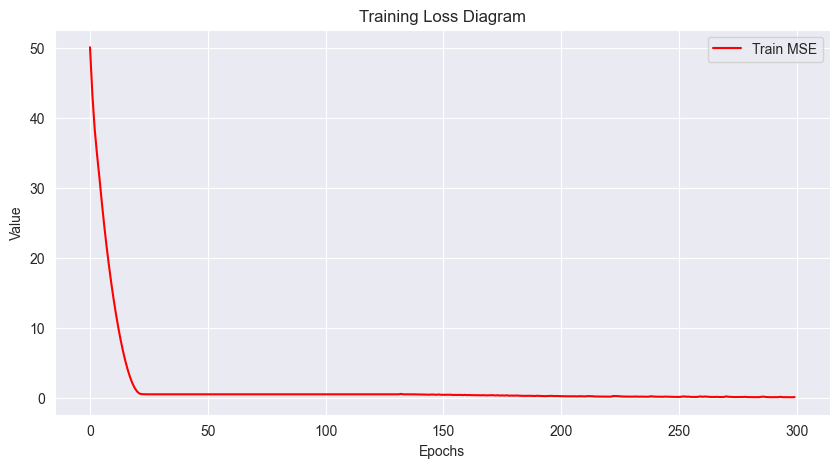

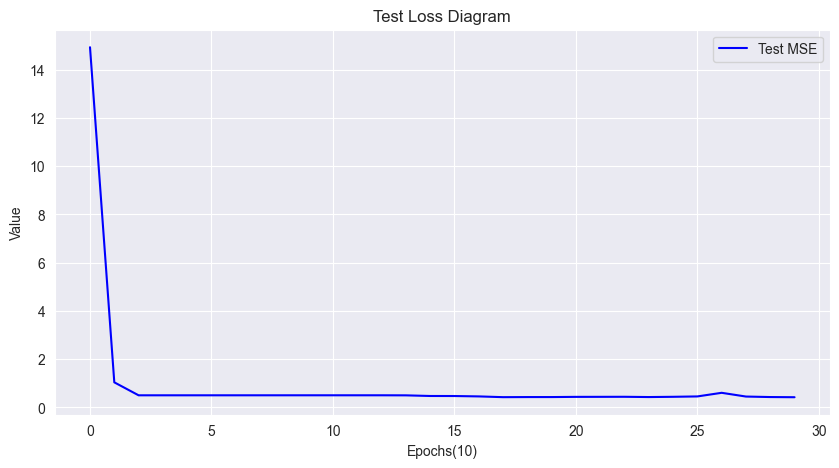

Final Epoch, train loss:0.14456130591431968 and test loss:0.4192183877797735.
MAE: 0.4563983082771301 and MSE: 0.41921839118003845.


In [21]:
from torch.nn.functional import *

# visualization
plt.figure(figsize=(10, 5))
plt.plot(loss_history, 'r', label='Train MSE')
plt.title('Training Loss Diagram')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_loss_history[:], 'b', label='Test MSE')
plt.title('Test Loss Diagram')
plt.xlabel('Epochs(10)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
print(f'Final Epoch, train loss:{loss_history[-1]} and test loss:{test_loss_history[-1]}.')

inputs = X_test
targets = y_test
with torch.no_grad():
    outputs = model(inputs)
    # loss = criterion(targets, outputs)
    mse = mse_loss(targets, outputs)
    mae = l1_loss(targets, outputs)
    print(f'MAE: {mae} and MSE: {mse}.')